# UC-Berkeley Milling Dataset
> This notebook demonstrates how we can use PyPHM with the UC-Berkeley Milling Dataset. We also conduct some basic data exploration to help the reader understand the data.

The UC-Berkeley Milling Dataset is a collection of milling machine signals. In short, the dataset is made of 16 cases of milling tools performing cuts in metal. Six cutting parameters were used in the creation of the data: 

* the metal type (either cast iron or steel, labelled as 1 or 2 in the data set, respectively)
* the depth of cut (either 0.75 mm or 1.5 mm)
* the feed rate (either 0.25 mm/rev or 0.5 mm/rev)

Each of the 16 cases is a combination of the cutting parameters (for example, case one has a depth of cut of 1.5 mm, a feed rate of 0.5 mm/rev, and is performed on cast iron). 

The cases are made up of individual cuts from when the tool is new to degraded or worn. There are 167 cuts (called 'runs' in the documentation) amongst all 16 cases. Many of the cuts are accompanied by a measure of flank wear (VB). We'll use this to label the cuts as either as healthy, degraded, or worn.

Finally, six signals were collected during each cut: acoustic emission (AE) signals from the spindle and table; vibration from the spindle and table; and AC/DC current from the spindle motor. The signals were collected at 250 Hz and each cut has 9000 sampling points, for a total signal length of 36 seconds.

The dataset is available from the [NASA Prognostic Data Repository](https://www.nasa.gov/intelligent-systems-division/discovery-and-systems-health/pcoe/pcoe-data-set-repository/). Consider citing the creators of the dataset if you use it in academic research.

# Quickstart
Use PyPHM to quickly download and prepare the dataset.

**Only if** you are running in Google Colab, install PyPHM.

In [ ]:
# ONLY RUN IF YOU'RE USING GOOGLE COLAB
!pip install pyphm


Import PyPHM, numpy, pandas, and pathlib.

In [1]:
from pyphm.datasets.milling import MillingPrepMethodA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

%load_ext autoreload
%autoreload 2

We will use `MillingPrepMethodA` to prepare the dataset. This method is similar to that described in Cheng et al. [cheng2019multisensory] and von Hahn et al. [].

Instantiate the `MillingPrepMethodA` class. Dowload the dataset by setting `download` to `True`. Keep the sliding window length (`window_size`) to 64, and the amount each window moves (`stride`) to 64. These are also the default values, if you leave these variables blank.

In [2]:
# define the location of where the raw data folders will be kept.
# e.g. the milling data will be in path_data_raw_folder/milling/ 
path_data_raw_folder = Path(Path.cwd().parent / 'data/raw/' )
print(path_data_raw_folder)

# create the path_data_raw_folder if it does not exist
path_data_raw_folder.mkdir(parents=True, exist_ok=True)

# instantiate the MillingPrepMethodA class and download data if it does not exist
mill = MillingPrepMethodA(root=path_data_raw_folder, download=True)

/home/tim/Documents/PyPHM/data/raw
Attempting to download https://phm-datasets.s3.amazonaws.com/NASA/3.+Milling.zip


  0%|          | 0/14731306 [00:00<?, ?it/s]

Extracting /home/tim/Documents/PyPHM/data/raw/milling/3.+Milling.zip to /home/tim/Documents/PyPHM/data/raw/milling
Found nested archive: /home/tim/Documents/PyPHM/data/raw/milling/3. Milling/mill.zip
Successfully downloaded all files from aws


## Create Numpy Arrays
With the dataprep class instantiated, we can now prepare the dataset by calling methods from the class.

First, let's call the `create_xy_arrays` method. This will create two numpy arrays. The `x` array contains the windowed signals from the milling machine. The `y` array contains the labels and meta-data for each window.

In [3]:
x, y = mill.create_xy_arrays()
print("x.shape", x.shape)
print("y.shape", y.shape)

x.shape (11570, 64, 6)
y.shape (11570, 64, 3)


As can be seen, the `x` array has a shape of `(11570, 64, 6)`, representing `[no. samples, window length, no. signals]`. 

There are six signals in each sample (you can read more about the types of signals in the Data Exploration section, below). From index 0, to index 5, the signals are:

In [4]:
mill.signal_names

('AE_spindle', 'AE_table', 'vib_spindle', 'vib_table', 'smcDC', 'smcAC')

If you want to access the spindle vibration (`vib_spindle`) signal, you can index the numpy array like this:

In [5]:
# index into the 'vib_spindle' signal and show the shape
x[:,:,2].shape

(11570, 64)

The `y` array has a similar shape to `x`, but instead of signals, it contains the label and meta-data for each window. The shape of `y` is like this: `[no. samples, window length, no. label columns]`.

There are three label columns in `y_labels_ids_times`:
* Label column 1 (index 0): The label, or tool class, for each sample (window). Either `0` for healthy, `1` for degraded, or `2` for worn (failed). More details provided in the Data Exploration section.
* Label column 2 (index 1): The ID of the sample. e.g. `1_0` for the first sample of the first window.
* Label column 3 (index 2): The timesteps for each data point in each sample.

To access the label for each sample, you can index the `y` array like this:

In [6]:
# use the colon in the first index to get all of the 11570 samples
# use 0 in the second index to only get the first label for each data point of each sample
# use 0 in the third index to get the label (either 0, 1, or 2)
y_label = y[:,0,0]
print("y_label.shape", y_label.shape)
y_label

y_label.shape (11570,)


array(['0', '0', '0', ..., '1', '1', '1'], dtype='<U32')

The data in the `y` array is stored with a dtype of `<u32`, a unicode string. You likely want to convert the label column to an integer, like this:

In [7]:
y_label.astype(int)

array([0, 0, 0, ..., 1, 1, 1])

In this example, each window (sample) has a length of 64. The signals are collected at 250 Hz. This means that the timesteps are spaced by 1/250 = 0.004 seconds. Here are the timesteps, which we access from index 2 of the `y` array:

In [8]:
# show the timestep column, converted to `float` first
y[0,:,2].astype(float)

array([0.   , 0.004, 0.008, 0.012, 0.016, 0.02 , 0.024, 0.028, 0.032,
       0.036, 0.04 , 0.044, 0.048, 0.052, 0.056, 0.06 , 0.064, 0.068,
       0.072, 0.076, 0.08 , 0.084, 0.088, 0.092, 0.096, 0.1  , 0.104,
       0.108, 0.112, 0.116, 0.12 , 0.124, 0.128, 0.132, 0.136, 0.14 ,
       0.144, 0.148, 0.152, 0.156, 0.16 , 0.164, 0.168, 0.172, 0.176,
       0.18 , 0.184, 0.188, 0.192, 0.196, 0.2  , 0.204, 0.208, 0.212,
       0.216, 0.22 , 0.224, 0.228, 0.232, 0.236, 0.24 , 0.244, 0.248,
       0.252])

## Create Pandas Dataframe
The method, `create_xy_dataframe`, creates a flat pandas dataframe from the above `x` and `y` arrays. This flat dataframe is amenable to feature engineering using the [tsfresh](https://github.com/blue-yonder/tsfresh) feature engineering library.

Let's call the `create_xy_dataframe` method.

In [9]:
df = mill.create_xy_dataframe()
df.head()

,cut_id,cut_no,case,time,ae_spindle,ae_table,vib_spindle,vib_table,smcdc,smcac,tool_class
0,0_0,0,1,0.000,0.219727,0.272827,0.733643,2.116699,6.840820,0.124512,0
1,0_0,0,1,0.004,0.246582,0.322266,0.778809,2.277832,6.660156,-0.561523,0
2,0_0,0,1,0.008,0.294189,0.283813,0.758057,2.343750,6.508789,-2.099609,0
3,0_0,0,1,0.012,0.323486,0.260010,0.726318,2.448730,6.542969,-2.731934,0
4,0_0,0,1,0.016,0.290527,0.253296,0.653076,2.546387,6.621094,-3.505859,0


You can look at the shape of the dataframe and see that it is quite long. The dataframe is each sample stacked ontop of each other.

In [10]:
df.shape

(740480, 11)

Now we can slice and dice the dataframe, using pandas, to get what you want.

Let's select the cut number 56 from the dataframe.

In [11]:
df[df['cut_no'] == 56].head()

,cut_id,cut_no,case,time,ae_spindle,ae_table,vib_spindle,vib_table,smcdc,smcac,tool_class
248064,56_0,56,9,0.000,0.269775,0.234985,0.312500,1.179199,9.995117,-0.571289,1
248065,56_0,56,9,0.004,0.339966,0.256348,0.288086,1.093750,9.995117,-1.445312,1
248066,56_0,56,9,0.008,0.349121,0.280762,0.305176,1.259766,9.995117,-2.775879,1
248067,56_0,56,9,0.012,0.352173,0.241699,0.297852,1.298828,9.995117,-3.122559,1
248068,56_0,56,9,0.016,0.322266,0.238647,0.311279,1.162109,9.995117,-3.994141,1


In the Data Exploration section we'll discuss what the `cut_no`, `case`, and the various signal columns are.

# Data Exploration
Let's explore the UC-Berkeley Milling Dataset in detail. First, we should understand what milling is.

## What is milling?

In milling, a rotary cutter removes material as it moves along a work piece. Most often, milling is performed on metal – it's metal machining – and that’s what is happening in the UC Berkeley milling dataset.    

The picture below demonstrates a face milling procedure. The cutter is progressed forward while rotating. As the cutter rotates, the tool inserts “bite” into the metal and remove it. (image modified from [Wikipedia](https://commons.wikimedia.org/wiki/File:Fraisage_surfacage.svg#/media/File:Fraisage_surfacage.svg))

![face milling](./images/face_milling.png)

Over time, the tool inserts wear. Specifically, the flank of the tool wears, as shown below (image from author). In the UC Berkeley milling data set the flank wear (VB) is measured as the tool wears.

![flank wear](./images/flank_wear.png)

## Dataset Structure
Of course, the PyPHM module absracts aways the complexity of loading and preprocessing the dataset. However, it is good for us to understand the structure of the dataset. To do that, we'll load the dataset manually.

The UC Berkeley milling dataset is contained in a structured MATLAB array. We can load the `.mat` file using the `scipy.io` module and the `loadmat` function.

Since we have already downloaded the dataset, we can load it from the local directory.

In [12]:
# import matplotlib, seaborn, and scipy
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as sio # for reading matlab files

# load the data from the matlab file
mill_matfile = sio.loadmat(path_data_raw_folder / 'milling' / 'mill.mat',struct_as_record=True)

The data is stored as a dictionary. Let's look to see what it is made of.

In [13]:
# show some of the info from the matlab file
print('Keys in the matlab dict file: \n', mill_matfile.keys(), '\n')

Keys in the matlab dict file: 
 dict_keys(['__header__', '__version__', '__globals__', 'mill']) 



Only the 'mill' part of the dictionary contains useful information. We'll put that in a new numpy array called 'data.

In [14]:
# check to see what m['mill'] is
print(type(mill_matfile['mill']))

# store the 'mill' data in a seperate np array
data = mill_matfile['mill']

<class 'numpy.ndarray'>


This raw "data" array can also be accessed through the `MillingPrepMethodA` by calling the `load_mat` method. Let's do that and use it going forward.

In [15]:
data = mill.load_mat()

We now want to see what the 'data' array is made up of.

In [16]:
# store the field names in the data np array in a tuple, l
l = data.dtype.names
print('List of the field names:\n',l)

List of the field names:
 ('case', 'run', 'VB', 'time', 'DOC', 'feed', 'material', 'smcAC', 'smcDC', 'vib_table', 'vib_spindle', 'AE_table', 'AE_spindle')


Here's more information on each of the fields in the 'data' array:

* `case` - The case number (from 1 to 16).
* `run` - The run number (from 1 to 167).
* `VB` - The measured flank wear, in mm.
* `time` - Cumulative duration of after each run, in minutes (restarts after each case).
* `DOC` - The depth of cut, in mm (either 0.75 mm or 1.5 mm)
* `feed` - The feed rate, in mm/rev (either 0.25 mm/rev or 0.5 mm/rev)
* `material` - The material used (either cast iron or steel, labelled as 1 or 2 in the data set, respectively)
* `smAC` - AC spindle motor current
* `smDC` - DC spindle motor current
* `vib_table` - Table vibration
* `vib_spindle` - Spindle vibration
* `AE_table` - Acoustic emission from the table
* `AE_spindle` - Acoustic emission from the spindle

## Visualization
Let's visualize some of the data to understand it better.

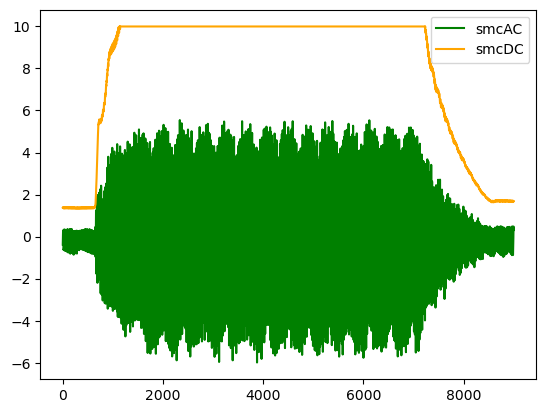

In [17]:
# look at cut number 167 (index 166)
fig, ax = plt.subplots()

ax.plot(data[0,166]['smcAC'],'g-',label='smcAC')
ax.plot(data[0,166]['smcDC'],color='orange',label='smcDC')

plt.legend()

If you look at all the cuts, you'll find that cuts 18 and 95 (index 17 and 94) are off -- they should be discarded.

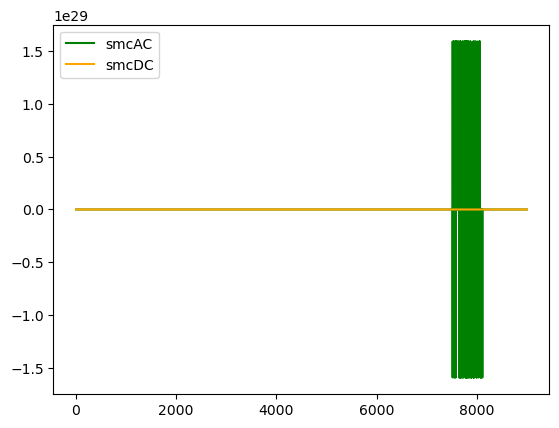

In [18]:
fig, ax = plt.subplots()

ax.plot(data[0,17]['smcAC'],'g-',label='smcAC')
ax.plot(data[0,17]['smcDC'],color='orange',label='smcDC')

plt.legend()

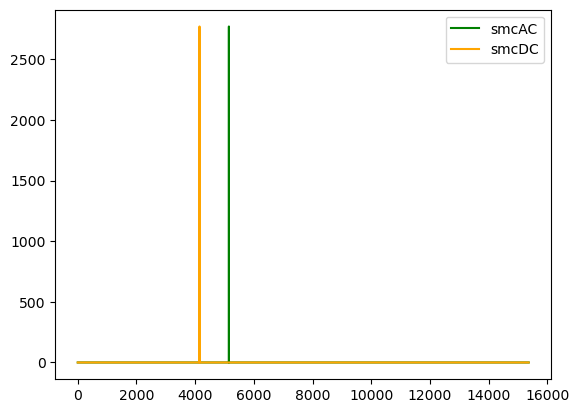

In [19]:
fig, ax = plt.subplots()

ax.plot(data[0,94]['smcAC'],'g-',label='smcAC')
ax.plot(data[0,94]['smcDC'],color='orange',label='smcDC')

plt.legend()

Cut 106 is also weird...

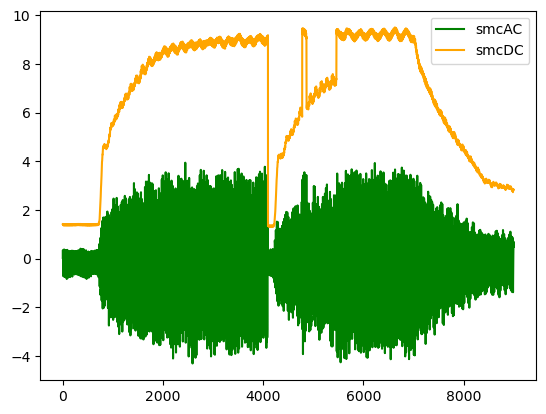

In [20]:
fig, ax = plt.subplots()

ax.plot(data[0,105]['smcAC'],'g-',label='smcAC')
ax.plot(data[0,105]['smcDC'],color='orange',label='smcDC')

plt.legend()

We'll create a pretty plot of all the six signals for a certain cut.

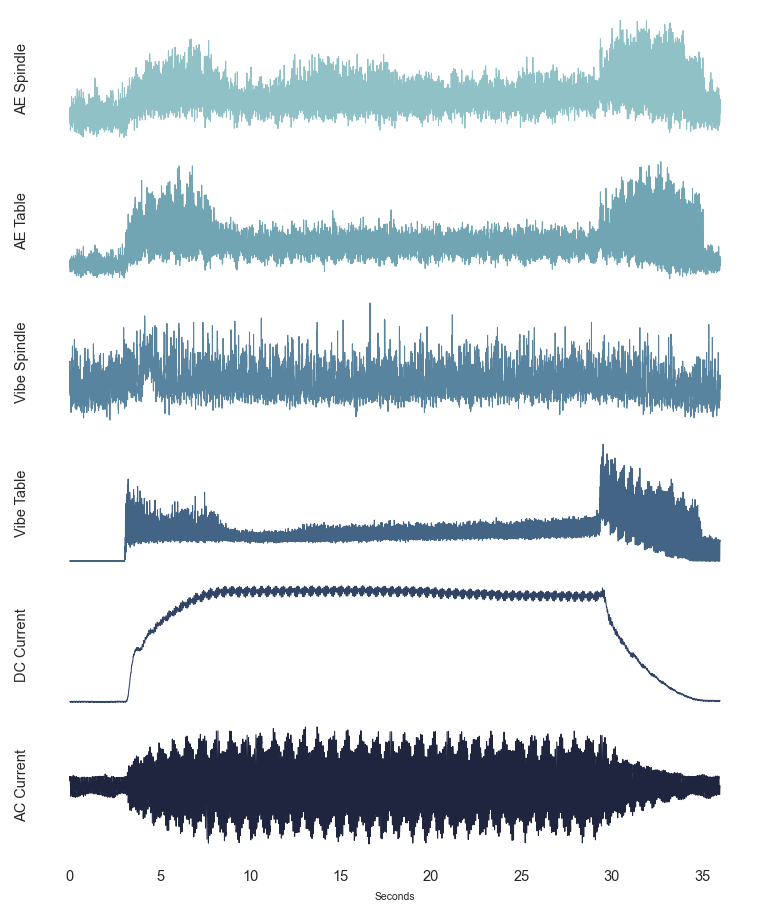

In [21]:
def plot_cut(cut_signal, signals_trend, cut_no):

    # define colour palette and seaborn style
    pal = sns.cubehelix_palette(6, rot=-0.25, light=0.7)
    sns.set(style="white", context="notebook")

    fig, axes = plt.subplots(
        6, 1, dpi=150, figsize=(5, 6), sharex=True, constrained_layout=True,
    )

    # the "revised" signal names so it looks good on the chart
    signal_names_revised = [
        "AE Spindle",
        "AE Table",
        "Vibe Spindle",
        "Vibe Table",
        "DC Current",
        "AC Current",
    ]

    # go through each of the signals
    for i in range(6):
        # plot the signal
        # note, we take the length of the signal (9000 data point)
        # and divide it by the frequency (250 Hz) to get the x-axis
        # into seconds
        axes[i].plot(np.arange(0,9000)/250.0, 
                     cut_signal[signals_trend[i]], 
                     color=pal[i], 
                     linewidth=0.5, 
                     alpha=1)
        
        axis_label = signal_names_revised[i]
        
        axes[i].set_ylabel(
            axis_label, fontsize=7,
        )

        # if it's not the last signal on the plot
        # we don't want to show the subplot outlines
        if i != 5:
            axes[i].spines["top"].set_visible(False)
            axes[i].spines["right"].set_visible(False)
            axes[i].spines["left"].set_visible(False)
            axes[i].spines["bottom"].set_visible(False)
            axes[i].set_yticks([]) # also remove the y-ticks, cause ugly
        
        # for the last signal we will show the x-axis labels
        # which are the length (in seconds) of the signal
        else:
            axes[i].spines["top"].set_visible(False)
            axes[i].spines["right"].set_visible(False)
            axes[i].spines["left"].set_visible(False)
            axes[i].spines["bottom"].set_visible(False)
            axes[i].set_yticks([])
            axes[i].tick_params(axis="x", labelsize=7)
            axes[i].set_xlabel('Seconds', size=5)


signals_trend = list(l[7:])  # there are 6 types of signals, smcAC to AE_spindle
signals_trend = signals_trend[::-1]  # reverse the signal order so that it is matching other charts

# we'll plot signal 146 (index 145)
cut_signal = data[0, 145]

plot_cut(cut_signal, signals_trend, "cut_146")
# plt.savefig('cut_signals.png',format='png') # save the figure if you want
plt.show()

# Data Prep
There are many possible ways to prepare the UC Berekeley milling dataset. Here, we demonstrate `MillingPrepMethodA`. This method is similar to that used by von Hahn et al. and Cheng et al. [1, 2].

Of course, we need the raw signal data from the spindle motors, vibrations etc. However, we also need the labels for each sample and the meta-data surrounding it.

The `create_labels` method in the `MillingPrepMethodA` class creates a table of the labels for each sample. However, let's be explicit -- we'll recreate the same function here so we can learn from it.

In [22]:
field_names = data.dtype.names
field_names

('case',
 'run',
 'VB',
 'time',
 'DOC',
 'feed',
 'material',
 'smcAC',
 'smcDC',
 'vib_table',
 'vib_spindle',
 'AE_table',
 'AE_spindle')

In [23]:
# store the field names in the data np array in a tuple
field_names = data.dtype.names

# create empty dataframe for the labels
df_labels = pd.DataFrame()

# get the labels from the original .mat file and put in dataframe
for i in range(7):
    # list for storing the label data for each field
    x = []

    # iterate through each of the unique cuts
    for j in range(167):
        x.append(data[0, j][i][0][0])
    x = np.array(x)
    df_labels[str(i)] = x

# add column names to the dataframe
df_labels.columns = field_names[0:7]

# create a column with the unique cut number
df_labels["cut_no"] = [i for i in range(167)]

df_labels.head()

,case,run,VB,time,DOC,feed,material,cut_no
0,1,1,0.00,2,1.5,0.5,1,0
1,1,2,NaN,4,1.5,0.5,1,1
2,1,3,NaN,6,1.5,0.5,1,2
3,1,4,0.11,7,1.5,0.5,1,3
4,1,5,NaN,11,1.5,0.5,1,4


Let's create a new dataframe with just the case, DOC, feed, and material columns.

In [24]:
# create df with just the case, DOC, feed, and material columns, and keep only unique rows
df_labels_short = df_labels[["case", "DOC", "feed", "material"]].drop_duplicates()
df_labels_short["material"] = df_labels_short["material"].replace({1: "cast iron", 2: "steel"})
df_labels_short.columns = ["Case", "Depth of Cut (mm)", "Feed Rate (mm/rev)", "Material"]
df_labels_short = df_labels_short.sort_values(by=["Case"], ascending=True).reset_index(drop=True)

# save df_labels_short as latex table (if you want)
# df_labels_short.to_latex("labels_short.tex", index=False)

df_labels_short

,Case,Depth of Cut (mm),Feed Rate (mm/rev),Material
0,1,1.50,0.50,cast iron
1,2,0.75,0.50,cast iron
2,3,0.75,0.25,cast iron
3,4,1.50,0.25,cast iron
4,5,1.50,0.50,steel
5,6,1.50,0.25,steel
6,7,0.75,0.25,steel
7,8,0.75,0.50,steel
8,9,1.50,0.50,cast iron
9,10,1.50,0.25,cast iron


You can see in the dataframe above, that there are several NaNs values for the wear (VB). That's ok. We will use categories for tool wear, and this will become our "label". We can then fill in the empty labels that have no associated value for VB. The categories (labels) will be:

* Healthy Sate (label=0): 0~0.2mm flank wear
* Degredation State (label=1): 0.2~0.7mm flank wear
* Failure State (label=2): >0.7mm flank wear

This little function will create the label column, which we call `tool_class`.

In [25]:
def tool_state(cols):
    """Add the label to the cut."""
    vb = cols

    if vb < 0.2:
        return 0
    elif vb >= 0.2 and vb < 0.7:
        return 1
    elif pd.isnull(vb):
        pass
    else:
        return 2

# apply the label to the dataframe
df_labels["tool_class"] = df_labels["VB"].apply(tool_state)
df_labels.head()

,case,run,VB,time,DOC,feed,material,cut_no,tool_class
0,1,1,0.00,2,1.5,0.5,1,0,0.0
1,1,2,NaN,4,1.5,0.5,1,1,NaN
2,1,3,NaN,6,1.5,0.5,1,2,NaN
3,1,4,0.11,7,1.5,0.5,1,3,0.0
4,1,5,NaN,11,1.5,0.5,1,4,NaN


You can visually inspect the labels (tool class) and infer what the `tool_class` should be for NaN values. This has already be done and saved as a package resource (`milling_labels_with_tool_class.csv`). The path of this csv can be accessed through the class variable `labels_with_tool_class`. We can also load the pandas dataframe via the `df_labels` class variable.

In [26]:
df_labels = mill.df_labels
df_labels.head()

,case,run,VB,time,DOC,feed,material,cut_no,tool_class,window_start,window_end
0,1,1,0.00,2,1.5,0.5,1,0,0,2496,6976
1,1,2,NaN,4,1.5,0.5,1,1,0,2496,6976
2,1,3,NaN,6,1.5,0.5,1,2,0,2496,6976
3,1,4,0.11,7,1.5,0.5,1,3,0,2496,6976
4,1,5,NaN,11,1.5,0.5,1,4,0,2496,6976


Note the `window_start` and `window_end` columns. These are hand selected for when the cuts are in a stable cutting state (e.g. the tool is not being sped up or slowing down).

The best way to see this is to visualize a cut with the `window_start` and `window_end`.

window_start: 2496
window_end: 6976


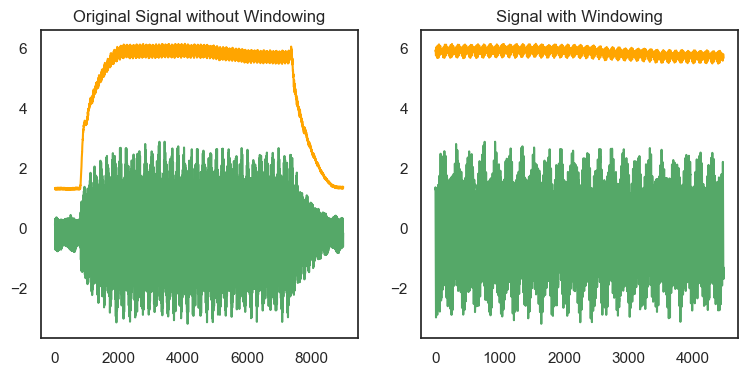

In [27]:
# we'll plot signal 146 (index 145) again
cut_no = 145

# get the start and end index for the window
window_start = df_labels[df_labels['cut_no'] == cut_no]['window_start'].values[0]
window_end = df_labels[df_labels['cut_no'] == cut_no]['window_end'].values[0]

print('window_start:', window_start)
print('window_end:', window_end)

cut_signal = data[0, 145]

fig, ax = plt.subplots(1, 2, figsize=(9, 4))

ax[0].plot(cut_signal['smcAC'],'g-')
ax[0].plot(cut_signal['smcDC'],color='orange')
ax[0].set_title('Original Signal without Windowing')

ax[1].plot(cut_signal['smcAC'][window_start:window_end],'g-')
ax[1].plot(cut_signal['smcDC'][window_start:window_end],color='orange')
ax[1].set_title('Signal with Windowing')
plt.show()